# new WS brightness curve measurement



In [1]:
%run myToolbox.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-862.14.4.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/user/e/esenes/Emittance-measurement-accuracy-precision-study
Your IP is 172.17.0.3
2018-11-01 09:12:29


In [2]:
# %run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'

---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


# User inputs

In [3]:
matlabVars = ['PR_BPM.AcquisitionOrbit.value.position', # BPMs
              'PR_BPM.AcquisitionMean.value.position',
                'PR_BPM.AcquisitionOrbit.value.channelNames',
                'PR_BCT_ST.Samples.value.samples'
             ]

In [4]:
filenames = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.24_new_WS+BGI_brightness_curve/data/*.mat'))
myDataFrame = myToolbox.fromMatlabToDataFrame(filenames,matlabVars,verbose=False)


# Intensity

In [5]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Intensity'] = myDataFrame['Intensity'].apply(lambda x: np.mean(x[500:900]))

In [6]:
# add the intensity from TIMBER
# Alex's way
ts1 = '2018-10-24 11:35:58.000'
ts2 = '2018-09-24 14:28:00.000'

PSuser = 'CPS:MD4404_BCMS:MD7'

variables = ['PR.DCAFTINJ_1:INTENSITY']

myToolbox.addToDataFrameFromCALS(myDataFrame, variables)

# BPMs to mm

In [94]:
myDataFrame['PR_BPM.AcquisitionOrbit.value.position'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: 0.1*x)
myDataFrame['PR_BPM.AcquisitionMean.value.position'] = myDataFrame['PR_BPM.AcquisitionMean.value.position'].apply(lambda x: 0.1*x)


# Import Jose's data

In [8]:
# import to dict
matlabVars2 = ['Sigmas_IN','Sigmas_OUT','Centres_IN','Centres_OUT','InfoData_CycleName','']
new_WS_data = scipy.io.loadmat('/eos/user/e/esenes/Emittance-measurement-accuracy-precision-study/new_WS_brightness/Summary_Processed.mat', squeeze_me=True, struct_as_record=False)
# fix the casting for the timestamps
liuTs = []
for k in range(263):    
    ts = new_WS_data['InfoData_CycleName'][k]
    ts_unix = time.mktime(datetime.datetime.strptime(str(ts), '%Y.%m.%d.%H.%M.%S.%f').timetuple())
    liuTs.append(myToolbox.unixtime2datetime(ts_unix))
# import to dataframe
LIU_df = pnd.DataFrame([],index=liuTs)

# cleanup faulty data
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-24 10:20:40'].index)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-24 10:30:52'].index)

# populate the dataframe
LIU_df['Sigmas_IN'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Sigmas_OUT'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Centre_IN'] = [np.empty(4,dtype=float)]*len(LIU_df)
LIU_df['Centre_OUT'] = [np.empty(4,dtype=float)]*len(LIU_df)

for k, l in enumerate(LIU_df.index):
    LIU_df['Sigmas_IN'].loc[l] = new_WS_data['Sigmas_IN'][k]
    LIU_df['Sigmas_OUT'].loc[l] = new_WS_data['Sigmas_OUT'][k]
    LIU_df['Centre_IN'].loc[l] = new_WS_data['Centres_IN'][k]
    LIU_df['Centre_OUT'].loc[l] = new_WS_data['Centres_OUT'][k]
    
# UTC time fix --> go all in local time
LIU_df.index = LIU_df.index + pnd.DateOffset(hours=2, milliseconds=100)

# head/tail chop
LIU_df = LIU_df.drop(LIU_df.iloc[:9].index,axis=0)
# LIU_df = LIU_df.drop(LIU_df.iloc[148:].index,axis=0)

In [10]:
# manual adjustment of the data not matching ...
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab

LIU_df = LIU_df.drop(LIU_df.loc['2018-10-24 11:27:17.100000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-24 11:31:00.100000'].name)

myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 10:40:15.100'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 11:20:28.300000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 11:21:05.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 11:26:40.300000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 11:31:00.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 12:20:40.300000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 12:21:21.100000'].name)

# drops for the matlab off period
id_to_drop = ['2018-10-24 12:30:11.100000', '2018-10-24 12:32:13.100000',
               '2018-10-24 12:32:54.100000', '2018-10-24 12:33:35.100000',
               '2018-10-24 12:34:16.100000', '2018-10-24 12:34:57.100000',
               '2018-10-24 12:35:37.100000', '2018-10-24 12:36:18.100000',
               '2018-10-24 12:36:59.100000', '2018-10-24 12:37:40.100000',
               '2018-10-24 12:38:21.100000', '2018-10-24 12:39:01.100000',
               '2018-10-24 12:39:42.100000', '2018-10-24 12:40:23.100000',
               '2018-10-24 12:41:04.100000', '2018-10-24 12:41:45.100000',
               '2018-10-24 12:42:25.100000', '2018-10-24 12:43:06.100000',
               '2018-10-24 12:43:47.100000', '2018-10-24 12:44:28.100000',
               '2018-10-24 12:45:09.100000', '2018-10-24 12:45:49.100000',
               '2018-10-24 12:46:30.100000', '2018-10-24 12:47:11.100000',
               '2018-10-24 12:47:52.100000', '2018-10-24 12:48:33.100000',
               '2018-10-24 12:49:13.100000', '2018-10-24 12:50:12.100000',
               '2018-10-24 12:50:48.100000', '2018-10-24 12:51:24.100000',
               '2018-10-24 12:52:00.100000', '2018-10-24 12:52:36.100000',
               '2018-10-24 12:53:12.100000', '2018-10-24 12:53:48.100000',
               '2018-10-24 12:54:24.100000', '2018-10-24 12:55:00.100000',
               '2018-10-24 12:55:36.100000']
for idx in id_to_drop:
    LIU_df = LIU_df.drop(LIU_df.loc[idx].name)
    
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 12:57:24.700000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-24 12:56:48.100000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-24 12:57:24.100000'].name)
LIU_df = LIU_df.drop(LIU_df.loc['2018-10-24 13:10:00.100000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:17:12.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:18:24.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:19:36.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:20:12.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:21:24.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:22:36.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:23:48.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:25:00.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:25:36.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:26:12.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:27:24.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:28:00.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:29:12.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:29:48.700000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:31:00.700000 '].name)

myDataFrame = myDataFrame.drop(myDataFrame.iloc[207:].index,axis=0)
                
                       

Dropped 3 duplicate(s)
---


In [11]:
myDataFrame['Sigmas_IN'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Sigmas_OUT'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Centre_IN'] = [np.empty(4,dtype=float)]*len(myDataFrame)
myDataFrame['Centre_OUT'] = [np.empty(4,dtype=float)]*len(myDataFrame)

for k in range(len(myDataFrame)):
    myDataFrame['Sigmas_IN'].iloc[k] = LIU_df['Sigmas_IN'].iloc[k]
    myDataFrame['Sigmas_OUT'].iloc[k] = LIU_df['Sigmas_OUT'].iloc[k]
    myDataFrame['Centre_IN'].iloc[k] = LIU_df['Centre_IN'].iloc[k]
    myDataFrame['Centre_OUT'].iloc[k] = LIU_df['Centre_OUT'].iloc[k]


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Finally the plot

In [ ]:
# bad fits cleanup
idx_to_drop = myDataFrame.loc[(myDataFrame['Sigmas_IN'].apply(lambda x : np.abs(sig(x,1)))>5) | (myDataFrame['Sigmas_IN'].apply(lambda x : np.abs(sig(x,1)))<3)].index

for idx in idx_to_drop:
    myDataFrame = myDataFrame.drop(myDataFrame.loc[idx].name)
    
    
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:09:24.700'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-10-24 13:32:12.700'].name)


In [84]:
# data grabber
def sig(x, idx):
    try:
        return x[idx]
    except:
        return x

# linear fitting
from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

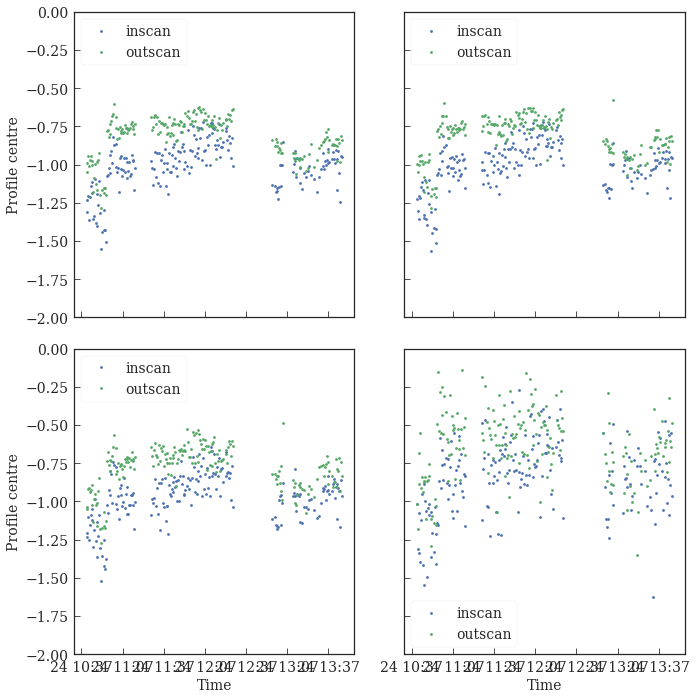

In [90]:
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True, sharey=True)

x0 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,0))
x1 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,1))
x2 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,2))
x3 = myDataFrame['Centre_IN'].apply(lambda x : sig(x,3))

ax[0,0].plot(x0,'.',label='inscan')
ax[0,1].plot(x1,'.',label='inscan')
ax[1,0].plot(x2,'.',label='inscan')
ax[1,1].plot(x3,'.',label='inscan')

x0 = myDataFrame['Centre_OUT'].apply(lambda x : sig(x,0))
x1 = myDataFrame['Centre_OUT'].apply(lambda x : sig(x,1))
x2 = myDataFrame['Centre_OUT'].apply(lambda x : sig(x,2))
x3 = myDataFrame['Centre_OUT'].apply(lambda x : sig(x,3))

ax[0,0].plot(x0,'.',label='outscan')
ax[0,1].plot(x1,'.',label='outscan')
ax[1,0].plot(x2,'.',label='outscan')
ax[1,1].plot(x3,'.',label='outscan')

ax[0,0].set_ylim(-2,0)
ax[1,0].set_ylim(-2,0)

ax[0,0].legend(frameon=True)
ax[0,1].legend(frameon=True)
ax[1,0].legend(frameon=True)
ax[1,1].legend(frameon=True)

ax[0,0].set_ylabel('Profile centre')
ax[1,0].set_ylabel('Profile centre')
ax[1,0].set_xlabel('Time')
ax[1,1].set_xlabel('Time')

fig.tight_layout()

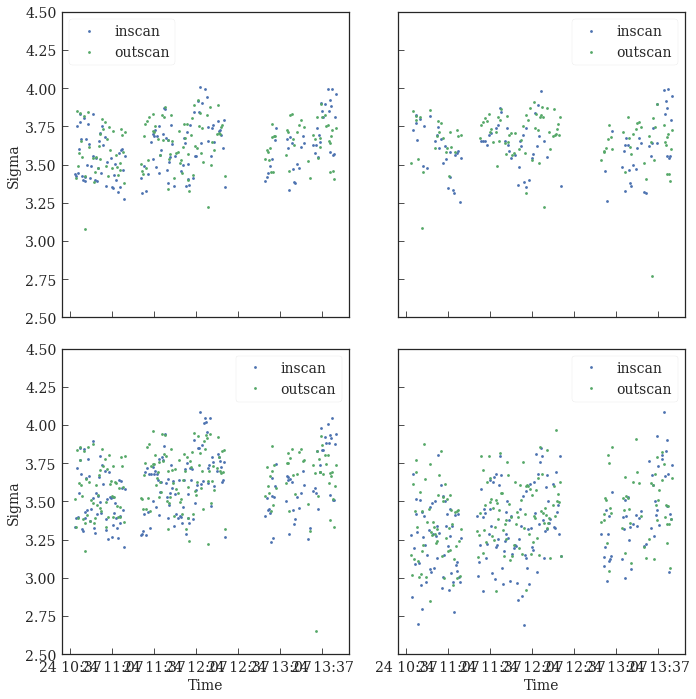

In [91]:
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True, sharey=True)

x0 = myDataFrame['Sigmas_IN'].apply(lambda x : sig(x,0))
x1 = myDataFrame['Sigmas_IN'].apply(lambda x : sig(x,1))
x2 = myDataFrame['Sigmas_IN'].apply(lambda x : sig(x,2))
x3 = myDataFrame['Sigmas_IN'].apply(lambda x : sig(x,3))

ax[0,0].plot(x0,'.',label='inscan')
ax[0,1].plot(x1,'.',label='inscan')
ax[1,0].plot(x2,'.',label='inscan')
ax[1,1].plot(x3,'.',label='inscan')

x0 = myDataFrame['Sigmas_OUT'].apply(lambda x : sig(x,0))
x1 = myDataFrame['Sigmas_OUT'].apply(lambda x : sig(x,1))
x2 = myDataFrame['Sigmas_OUT'].apply(lambda x : sig(x,2))
x3 = myDataFrame['Sigmas_OUT'].apply(lambda x : sig(x,3))

ax[0,0].plot(x0,'.',label='outscan')
ax[0,1].plot(x1,'.',label='outscan')
ax[1,0].plot(x2,'.',label='outscan')
ax[1,1].plot(x3,'.',label='outscan')

ax[0,0].set_ylim(2.5, 4.5)
ax[1,0].set_ylim(2.5, 4.5)

ax[0,0].legend(frameon=True)
ax[0,1].legend(frameon=True)
ax[1,0].legend(frameon=True)
ax[1,1].legend(frameon=True)

ax[0,0].set_ylabel('Sigma')
ax[1,0].set_ylabel('Sigma')
ax[1,0].set_xlabel('Time')
ax[1,1].set_xlabel('Time')

fig.tight_layout()

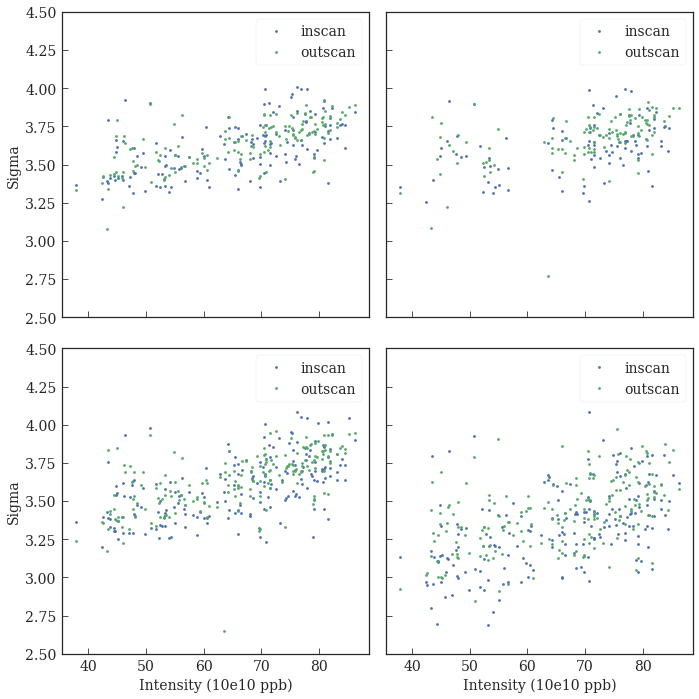

In [92]:
fig, ax = plt.subplots(2,2,figsize=(10,10),sharex=True, sharey=True)

x0 = myDataFrame['Sigmas_IN'].apply(lambda x : sig(x,0))
x1 = myDataFrame['Sigmas_IN'].apply(lambda x : sig(x,1))
x2 = myDataFrame['Sigmas_IN'].apply(lambda x : sig(x,2))
x3 = myDataFrame['Sigmas_IN'].apply(lambda x : sig(x,3))
xx = myDataFrame['PR.DCAFTINJ_1:INTENSITY']

ax[0,0].plot(xx, x0,'.',label='inscan')
ax[0,1].plot(xx, x1,'.',label='inscan')
ax[1,0].plot(xx, x2,'.',label='inscan')
ax[1,1].plot(xx, x3,'.',label='inscan')

x0 = myDataFrame['Sigmas_OUT'].apply(lambda x : sig(x,0))
x1 = myDataFrame['Sigmas_OUT'].apply(lambda x : sig(x,1))
x2 = myDataFrame['Sigmas_OUT'].apply(lambda x : sig(x,2))
x3 = myDataFrame['Sigmas_OUT'].apply(lambda x : sig(x,3))

ax[0,0].plot(xx, x0,'.',label='outscan')
ax[0,1].plot(xx, x1,'.',label='outscan')
ax[1,0].plot(xx, x2,'.',label='outscan')
ax[1,1].plot(xx, x3,'.',label='outscan')

ax[0,0].set_ylim(2.5, 4.5)
ax[1,0].set_ylim(2.5, 4.5)

ax[0,0].legend(frameon=True)
ax[0,1].legend(frameon=True)
ax[1,0].legend(frameon=True)
ax[1,1].legend(frameon=True)

ax[0,0].set_ylabel('Sigma')
ax[1,0].set_ylabel('Sigma')
ax[1,0].set_xlabel('Intensity (10e10 ppb)')
ax[1,1].set_xlabel('Intensity (10e10 ppb)')

fig.tight_layout()



PM A
(array([  3.59137569e+00,  -8.89846302e-03,   1.32222038e-04]), array([  3.09563166e-01,   1.00371353e-02,   7.88719319e-05]))
PM B
(array([  3.54300600e+00,  -7.41764937e-03,   1.19114596e-04]), array([  3.08202544e-01,   9.99301909e-03,   7.85252646e-05]))
PM C
(array([  3.52825206e+00,  -8.42720131e-03,   1.38106904e-04]), array([  3.42926858e-01,   1.11189047e-02,   8.73724893e-05]))
PM D
(array([  2.72636993e+00,   7.47641066e-03,   2.54159725e-05]), array([  4.62399225e-01,   1.49926227e-02,   1.17812213e-04]))


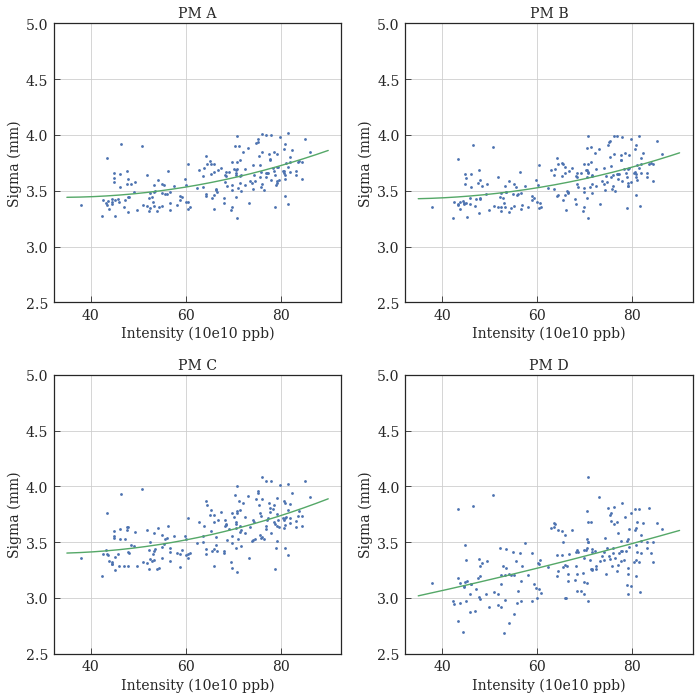

In [83]:
def parab(x, a, b, c):
    return a + (b*x) + (c*x*x)

fig, ax = plt.subplots(2,2,figsize=(10,10))

x0 = myDataFrame['Sigmas_IN'].apply(lambda x : np.abs(sig(x,0)))
x1 = myDataFrame['Sigmas_IN'].apply(lambda x : np.abs(sig(x,1)))
x2 = myDataFrame['Sigmas_IN'].apply(lambda x : np.abs(sig(x,2)))
x3 = myDataFrame['Sigmas_IN'].apply(lambda x : np.abs(sig(x,3)))
yy = myDataFrame['PR.DCAFTINJ_1:INTENSITY']

def print_subplot(ax_obj, row, col, xdata, ydata, title):
    # plotting 
    ax_obj[row,col].set_title(title)
    ax_obj[row,col].plot(xdata, ydata,'.')
    ax_obj[row,col].set_xlabel('Intensity (10e10 ppb)')
    ax_obj[row,col].set_ylabel('Sigma (mm)')
    ax_obj[row,col].set_ylim(2.5,5)
    ax_obj[row,col].grid(True)
    # fitting 
    popt, pcov = curve_fit(parab, xdata, ydata )
    print(title)
    print(popt, np.sqrt(np.diag(pcov)))
    xfit = np.linspace(35,90,200)
    ax_obj[row,col].plot(xfit, parab(xfit, *popt),'-')

    
print_subplot(ax, 0, 0, yy, x0, 'PM A' )
print_subplot(ax, 0, 1, yy, x1, 'PM B' )
print_subplot(ax, 1, 0, yy, x2, 'PM C' )
print_subplot(ax, 1, 1, yy, x3, 'PM D' )

fig.tight_layout()

# BPMs scouting

- MRP is fine
- 

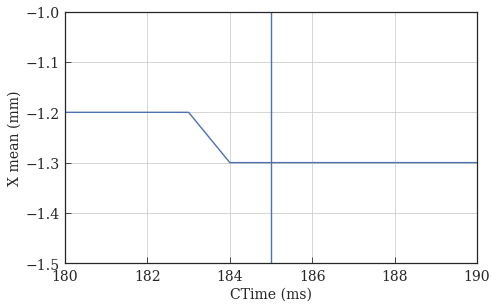

In [144]:
yy = myDataFrame['PR_BPM.AcquisitionMean.value.position'].iloc[0][0]
tscale = np.linspace(170, len(yy)+169, len(yy))

plt.plot(tscale, yy)
plt.xlim(180,190)
plt.ylim(-1.5,-1)
plt.grid(True)
plt.xlabel('CTime (ms)')
plt.ylabel('X mean (mm)')

yy[10:20]

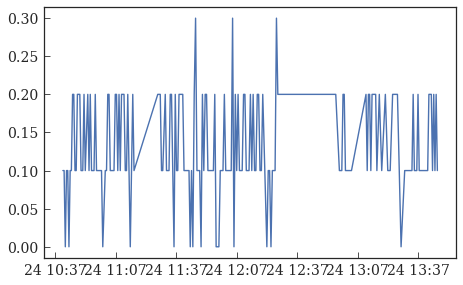

In [180]:
myDataFrame['MRP_change'] = myDataFrame['PR_BPM.AcquisitionMean.value.position'].apply(lambda x: np.max(x[0][10:20]) - np.min(x[0][20]))
plt.plot(myDataFrame['MRP_change'])

## Investigate the orbit

In [175]:
myDataFrame['PR_BPM.AcquisitionOrbit.value.channelNames'].iloc[0][22]

u'PR.BPM54.H'

Text(0,0.5,u'X mean (mm)')

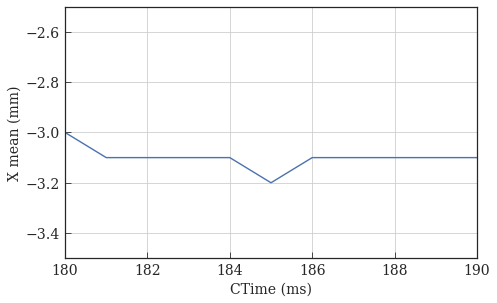

In [179]:
yy = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].iloc[0][22,:]

plt.plot(tscale, yy)
plt.xlim(180,190)
plt.ylim(-3.5,-2.5)
plt.grid(True)
plt.xlabel('CTime (ms)')
plt.ylabel('X mean (mm)')


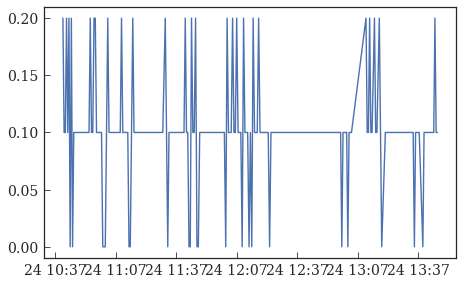

In [183]:
myDataFrame['Orbit_54_swing'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: np.max(x[22,10:20])- np.min(x[22,10:20]))
plt.plot(myDataFrame['Orbit_54_swing'])